<a href="https://colab.research.google.com/github/AmirhosseinSalamirad/House-Price-Valuation/blob/main/House_Price_Prediction%20-%20Zillow%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json, re, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def count_available_data(result_dir):
	n = 0
	counter = 0
	for filename in os.listdir(result_dir):
		if os.path.isdir(os.path.join(result_dir, filename)):
			json_file = os.path.join(result_dir, filename, 'Sold.json')
			data = open(json_file, 'r').readlines()[0]
			reformatted_data = re.sub('\\\\\"', "\'", data)
			q = json.loads(reformatted_data)
			print('Number of houses in the zipcode:\t', filename, ' is:\t', len(q))
			n += len(q)
			counter += 1
	print('Number of zipcodes =\t', counter)
	print('Total number of house =\t', n)
	print('Average house per zipcode =\t', n / counter)
	return n

In [ ]:
def get_required_data(result_dir):
	all_available_data = []

	for filename in os.listdir(result_dir):
		if os.path.isdir(os.path.join(result_dir, filename)):
			json_file = os.path.join(result_dir, filename, 'Sold.json')
			data = open(json_file, 'r').readlines()[0]
			reformatted_data = re.sub('\\\\\"', "\'", data)
			q = json.loads(reformatted_data)
			# get required properties

			for house_zpid, features in q.items():
				house_info = {}
				try:
					house_info['house_id'] = features['data']['property']['zpid']
					house_info['house_age'] = features['data']['property']['yearBuilt']
					house_info['livingArea'] = features['data']['property']['livingArea']
					house_info['zip_code'] = features['data']['property']['zipcode']
					house_info['homeType'] = features['data']['property']['homeType']
					house_info['number_of_bathrooms'] = features['data']['property']['bathrooms']
					house_info['number_of_bedrooms'] = features['data']['property']['bedrooms']
					house_info['house_lot_size'] = features['data']['property']['lotSize']
					house_info['has_basement'] = features['data']['property']['resoFacts']['basement']
					# house_info[has_elevator'] =
					house_info['has_pool'] = features['data']['property']['resoFacts']['hasPrivatePool']
					house_info['has_garage'] = features['data']['property']['resoFacts']['hasGarage']

					house_info['country'] = features['data']['property']['country']
					house_info['city'] = features['data']['property']['city']
					house_info['state'] = features['data']['property']['state']
					house_info['latitude'] = features['data']['property']['latitude']
					house_info['longitude'] = features['data']['property']['longitude']
					house_info['bathroomsFull'] = features['data']['property']['resoFacts']['bathroomsFull']
					house_info['bathroomsHalf'] = features['data']['property']['resoFacts']['bathroomsHalf']
					house_info['structureType'] = features['data']['property']['resoFacts']['structureType']
					house_info['stories'] = features['data']['property']['resoFacts']['stories']
					house_info['parking'] = features['data']['property']['resoFacts']['parking']
					house_info['basement'] = features['data']['property']['resoFacts']['basement']
					house_info['flooring'] = features['data']['property']['resoFacts']['flooring']
					house_info['heating'] = features['data']['property']['resoFacts']['heating']
					house_info['cooling'] = features['data']['property']['resoFacts']['cooling']
					house_info['cooling'] = features['data']['property']['resoFacts']['cooling']
					house_info['cooling'] = features['data']['property']['resoFacts']['cooling']
					house_info['cooling'] = features['data']['property']['resoFacts']['cooling']

					house_info['zestiamte'] = features['data']['property']['zestimate']
					house_info['sold_price'] = features['data']['property']['lastSoldPrice']

					all_available_data.append(house_info)
				except Exception as e:
					print('############ ERROR ############')
					print(e)
					print('zipcode =\t', filename)
					print('zpid =\t', house_zpid)
					print('############ ERROR ############')
	house_data_df = pd.DataFrame(all_available_data)
	house_data_df.to_csv('results.csv', index=False)
	return house_data_df

## train model function


In [ ]:
def train_model(dataset, base_model, params=None, verbose=0):
		# Append regressor to preprocessing pipeline.
	# Now we have a full prediction pipeline.


	numeric_features = ['house_age', 'livingArea', 'house_lot_size']
	numeric_transformer = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='mean')),
		('scaler', StandardScaler())
  ])

	categorical_features = ['homeType', 'state', 'structureType']
	categorical_transformer = Pipeline(steps=[
		# ('labelEncoder', preprocessing.LabelEncoder())
		('imputer', SimpleImputer(strategy='most_frequent')),
		('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))
  ])

	preprocessor = ColumnTransformer(
		transformers=[
			('num', numeric_transformer, numeric_features),
			('cat', categorical_transformer, categorical_features)
   					])

	# Append classifier to preprocessing pipeline.
	# Now we have a full prediction pipeline.
	pipe = Pipeline(steps=[
		('preprocessor', preprocessor),
		('regressor', base_model)],
		verbose=True)

	X = dataset.iloc[:, 1:-2]
	y = dataset.iloc[:, -1]
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
	if params:
		gs = GridSearchCV(pipe, params, cv=3, iid=False, n_jobs=-1, verbose=verbose)
		gs.fit(X, y)
		print("model score: {:.3}".format(gs.score(X_test, y_test)))
		print('Best Params:{}'.format(gs.best_params_))
		print('Best Score:{:.3}'.format(gs.best_score_))

	pipe.fit(X_train, y_train)
	# print model info and results
	# print('Model:\t{}'.format(str(model)))
	print('X_train.shape:\t{}'.format(X_train.shape))
	print('X_test.shape:\t{}'.format(X_test.shape))

	y_pred = pipe.predict(X_test)
	# mse = mean_squared_error(y_test, y_pred)
	# print('MSE = \t{:.10}'.format(mse))
	mae = mean_absolute_error(y_test, y_pred)
	print('MAE = \t{:.10}'.format(mae))
	# cv_score = cross_val_score(model, X_test, y_test, cv=5)
	# print('cv_score = \t{}'.format(cv_score))

	return pipe


In [ ]:
results = pd.read_csv('/content/drive/My Drive/results_v3.csv')
results.head()

,house_id,house_age,livingArea,zip_code,homeType,number_of_bathrooms,number_of_bedrooms,house_lot_size,has_basement,has_pool,has_garage,country,city,state,latitude,longitude,bathroomsFull,bathroomsHalf,structureType,stories,parking,basement,flooring,heating,cooling,zestiamte,sold_price
0,2089012599,NaN,NaN,840,LOT,NaN,NaN,31363.0,NaN,False,False,USA,St. Croix,VI,17.702918,-64.884460,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,220000.0
1,2085997000,NaN,3150.0,850,MULTI_FAMILY,4.0,5.0,42688.0,NaN,True,False,USA,St. Croix,VI,17.722526,-64.885484,NaN,NaN,NaN,0.0,NaN,NaN,['Ceramic'],NaN,NaN,NaN,969500.0
2,2115572201,NaN,2000.0,840,MULTI_FAMILY,3.0,3.0,5227.0,NaN,False,False,USA,Frederiksted,VI,17.710449,-64.881426,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,425000.0
3,2090502333,2015.0,2400.0,840,SINGLE_FAMILY,2.0,3.0,10454.0,NaN,False,False,USA,St. Croix,VI,17.712784,-64.873513,NaN,NaN,NaN,0.0,NaN,NaN,['Ceramic'],NaN,NaN,NaN,239900.0
4,2089012597,NaN,NaN,840,LOT,NaN,NaN,17424.0,NaN,False,False,USA,St. Croix,VI,17.703159,-64.883393,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,39000.0


In [ ]:
percent_missing = results.isnull().sum() * 100 / len(results)
missing_value_df = pd.DataFrame({'column_name': results.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
house_id,house_id,0.0
stories,stories,0.0
structureType,structureType,0.0
bathroomsHalf,bathroomsHalf,0.0
bathroomsFull,bathroomsFull,0.0
longitude,longitude,0.0
latitude,latitude,0.0
state,state,0.0
zestiamte,zestiamte,0.0
has_garage,has_garage,0.0


## remove missing values

In [ ]:
results  = results.drop(columns=['parking','country','city','heating','cooling','has_basement','basement','flooring'])

In [ ]:
results = results.dropna(axis=0, subset=['zestiamte','sold_price'])

In [ ]:
age = pd.DataFrame(2020-results['house_age'])
results['house_age'] = age

In [ ]:
mean_absolute_error(results['zestiamte'], results['sold_price'])

67499.74591623139

In [ ]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51117 entries, 8 to 57992
Data columns (total 19 columns):
house_id               51117 non-null int64
house_age              48204 non-null float64
livingArea             49338 non-null float64
zip_code               51117 non-null int64
homeType               51058 non-null object
number_of_bathrooms    45816 non-null float64
number_of_bedrooms     47553 non-null float64
house_lot_size         41973 non-null float64
has_pool               51117 non-null bool
has_garage             51117 non-null bool
state                  51116 non-null object
latitude               51117 non-null float64
longitude              51117 non-null float64
bathroomsFull          34806 non-null float64
bathroomsHalf          15393 non-null float64
structureType          32123 non-null object
stories                44020 non-null float64
zestiamte              51117 non-null float64
sold_price             51117 non-null float64
dtypes: bool(2), float64(12), 

In [ ]:
results.sample(5)

,house_id,house_age,livingArea,zip_code,homeType,number_of_bathrooms,number_of_bedrooms,house_lot_size,has_pool,has_garage,state,latitude,longitude,bathroomsFull,bathroomsHalf,structureType,stories,zestiamte,sold_price
24160,56143658,25.0,2938.0,1030,SINGLE_FAMILY,3.0,4.0,23522.0,True,True,MA,42.041992,-72.682872,2.0,1.0,Colonial,2.0,435142.0,400000.0
40566,86765120,50.0,1080.0,3307,SINGLE_FAMILY,1.0,1.0,827640.0,False,False,NH,43.312525,-71.520686,NaN,NaN,NaN,1.0,177800.0,152933.0
53139,56144833,30.0,2594.0,1001,SINGLE_FAMILY,2.5,4.0,43369.0,False,False,MA,42.039628,-72.630184,NaN,NaN,Contemporary,2.0,392627.0,371500.0
57724,56257121,60.0,1714.0,1002,SINGLE_FAMILY,2.0,3.0,20037.0,False,False,MA,42.356260,-72.515792,2.0,NaN,Ranch,1.0,421701.0,405000.0
29611,39288913,105.0,1330.0,7740,SINGLE_FAMILY,1.0,4.0,7501.0,False,False,NJ,40.306584,-73.992356,1.0,NaN,Colonial,0.0,187134.0,185000.0


In [ ]:
results = results.dropna()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9931 entries, 14 to 57989
Data columns (total 19 columns):
house_id               9931 non-null int64
house_age              9931 non-null float64
livingArea             9931 non-null float64
zip_code               9931 non-null int64
homeType               9931 non-null object
number_of_bathrooms    9931 non-null float64
number_of_bedrooms     9931 non-null float64
house_lot_size         9931 non-null float64
has_pool               9931 non-null bool
has_garage             9931 non-null bool
state                  9931 non-null object
latitude               9931 non-null float64
longitude              9931 non-null float64
bathroomsFull          9931 non-null float64
bathroomsHalf          9931 non-null float64
structureType          9931 non-null object
stories                9931 non-null float64
zestiamte              9931 non-null float64
sold_price             9931 non-null float64
dtypes: bool(2), float64(12), int64(2), object(3)

In [ ]:
# from sklearn import preprocessing

# x = results['house_age','livingArea'].values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled.min()

In [ ]:
results['state'].isnull().sum() * 100 / len(results)

0.0

In [ ]:
# si = SimpleImputer(strategy='most_frequent')
# results['homeType'] = si.fit_transform([results['homeType']])
# re

In [ ]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# results['homeType'] = le.fit_transform(results['homeType'])
# results['state'] = le.fit_transform(results['state'])
# results['structureType'] = le.fit_transform(results['structureType'])

## remove outliers


#### Z-score

In [ ]:
from scipy import stats
import numpy as np

q = results
print('results.shape before removal: {}'.format(results.shape))
results = results[results['sold_price']>40000]

for i in range(15):
    z = np.abs(stats.zscore(q['sold_price']))
    q = q[(z < 3)]
    # print(q.shape)

results = q
print('results.shape after removal: {}'.format(results.shape))

results.shape before removal: (9931, 19)
results.shape after removal: (8889, 19)


In [ ]:
X = results.iloc[:, 1:-2]
Y = results.iloc[:, -1]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8889 entries, 14 to 57988
Data columns (total 16 columns):
house_age              8889 non-null float64
livingArea             8889 non-null float64
zip_code               8889 non-null int64
homeType               8889 non-null object
number_of_bathrooms    8889 non-null float64
number_of_bedrooms     8889 non-null float64
house_lot_size         8889 non-null float64
has_pool               8889 non-null bool
has_garage             8889 non-null bool
state                  8889 non-null object
latitude               8889 non-null float64
longitude              8889 non-null float64
bathroomsFull          8889 non-null float64
bathroomsHalf          8889 non-null float64
structureType          8889 non-null object
stories                8889 non-null float64
dtypes: bool(2), float64(10), int64(1), object(3)
memory usage: 1.0+ MB


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

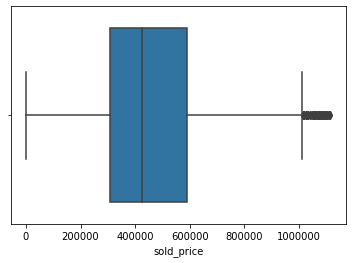

In [ ]:
import seaborn as sns
sns.boxplot(x=Y)

#### IQR Score

In [ ]:
# q = results
# print('results.shape before removal: {}'.format(results.shape))

# Q1 = q.quantile(0.25)
# Q3 = q.quantile(0.75)
# IQR = Q3 - Q1
# # print(IQR)
# q = q[~((q < (Q1 - 1.5 * IQR)) |(q > (Q3 + 1.5 * IQR))).any(axis=1)]
# results = q
# print('results.shape after removal: {}'.format(results.shape))

In [ ]:
# X = results.iloc[:, 1:-2]
# Y = results.iloc[:, -1]
# X.info()

In [ ]:
# Y.describe()

In [ ]:
# import seaborn as sns
# sns.boxplot(x=Y)

## Feature importance

In [ ]:
# from sklearn.ensemble import ExtraTreesRegressor
# import matplotlib.pyplot as plt
# model = ExtraTreesRegressor()
# model.fit(X,Y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

## Test models

### KNN

In [ ]:
%%time
regressor = neighbors.KNeighborsRegressor()
# params = None
params = {'regressor__n_neighbors': list(range(15,25)), 'regressor__weights': ['uniform', 'distance']}
# Best Params:{'regressor__n_neighbors': 24, 'regressor__weights': 'distance'}
train_model(results, regressor, params)

KeyboardInterrupt: ignored

### DTR


In [ ]:
%%time
regressor = DecisionTreeRegressor()
params = {'regressor__criterion': ('mse', 'friedman_mse', 'mae'), 'regressor__splitter': ('best', 'random')}
# Best Params:{'regressor__criterion': 'mae', 'regressor__splitter': 'best'}
# params = None
train_model(results, regressor, params)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total= 2.1min
model score: 0.967
Best Params:{'regressor__criterion': 'mae', 'regressor__splitter': 'best'}
Best Score:0.117
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.6s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.0s
X_train.shape:	(32097, 16)
X_test.shape:	(15810, 16)
MAE = 	122983.1665
CPU times: user 2min 13s, sys: 161 ms, total: 2min 13s
Wall time: 6min 3s


### SVR


In [ ]:
%%time
# SVR
regressor = SVR(gamma='auto')
# params = {'kernel': ['linear', 'poly', 'rbf'], 'C': [0.01, 0.1, 1, 5, 10]}
params = {'regressor__kernel': ['linear', 'poly', 'rbf']}
# params = None
train_model(results, regressor, params, verbose=10)
# train_model(results, regressor)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  2.1min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  2.2min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  3.8min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  3.8min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  3.8min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.8min remaining:    0.0s


KeyboardInterrupt: ignored

### GBoostRegressor


In [ ]:
%%time
regressor = GradientBoostingRegressor()
# regressor = GradientBoostingRegressor(
#         learning_rate = 0.1,
#         max_depth = 6,
#         max_features = 0.3,
#         min_samples_leaf = 9,
#         n_estimators = 100
#     )
params = None
# Best Params:{'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__max_features': 0.3, 'regressor__min_samples_leaf': 3, 'regressor__n_estimators': 100}
# params = {
#             'regressor__n_estimators':[100],
#             'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
#             'regressor__max_depth':[4,6],
#             'regressor__min_samples_leaf':[3,5,9,17],
#             'regressor__max_features':[1.0,0.3,0.1]
#         }

train_model(results, regressor, params)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.7s
X_train.shape:	(5955, 16)
X_test.shape:	(2934, 16)
MAE = 	98732.51675
CPU times: user 760 ms, sys: 4.14 ms, total: 764 ms
Wall time: 768 ms


In [ ]:
mean_absolute_error(results['zestiamte'], results['sold_price'])

33791.5987109905

### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
regressor = AdaBoostRegressor(GradientBoostingRegressor())
# regressor = AdaBoostRegressor(base_estimator=GradientBoostingRegressor(
#         learning_rate = 0.1,
#         max_depth = 6,
#         max_features = 0.3,
#         min_samples_leaf = 9,
#         n_estimators = 100
#     ))
params = None
params = {
            # 'regressor__n_estimators':[50],
            # 'regressor__learning_rate': [1, 0.5, 0.02],
            'regressor__loss':['linear', 'square', 'exponential'],
        }
# Best Params:{'regressor__loss': 'linear'}
train_model(results, regressor, params)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total= 1.3min
model score: 0.529
Best Params:{'regressor__loss': 'linear'}
Best Score:0.503
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  49.0s
X_train.shape:	(32097, 16)
X_test.shape:	(15810, 16)
MAE = 	100856.5152


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                               

### MLP


In [ ]:
%%time
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor()
params = {'regressor__activation':['identity','logistic', 'tanh', 'relu']}
train_model(results, regressor, params)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[Pipeline] ......... (step 1 of 1) Processing regressor, total=   8.3s
model score: -4.65
Best Params:{'regressor__activation': 'tanh'}
Best Score:-4.7


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[Pipeline] ......... (step 1 of 1) Processing regressor, total=   0.8s
X_train.shape:	(5925, 16)
X_test.shape:	(2919, 16)
MAE = 	406911.7737
CPU times: user 14.6 s, sys: 22.2 s, total: 36.8 s
Wall time: 36.6 s


## Results

| Regressor | With GridSearch  | Training Shape | MAE
|--------------------|---|-----------|------------|
|   KNN              | N |(32097, 16)| 102588.9181|
|   KNN              | Y |(32097, 16)| 102588.9181|
|   DTR              | N |(32097, 16)| 122973.528|
|   DTR              | Y |(32097, 16)| 122983.1665|
|   SVR              | N |(32097, 16)| |
|   SVR              | Y |(32097, 16)| |
|   GBoostRegressor  | N |(32097, 16)| 99020.46849|
|   GBoostRegressor  | Y |(32097, 16)| 99016.70906|
|   AdaBoost         | N |(32097, 16)| 100737.6465|
|   AdaBoost         | Y |(32097, 16)| 100856.5152|

In [ ]:
| Regressor          | With GridSearch | Training Shape | MAE        |
|--------------------|-----------------|----------------|------------|
|   KNN              | N               | (5955, 16)     |109498.6562 |
|   KNN              | Y               | (5955, 16)     |109498.6562 |
|   DTR              | N               | (5955, 16)     |            |
|   DTR              | Y               | (5955, 16)     |            |
|   SVR              | N               | (5955, 16)     |            |
|   SVR              | Y               | (5955, 16)     |            |
|   GBoostRegressor  | N               | (5955, 16)     |98715.63049 |
|   GBoostRegressor  | Y               | (5955, 16)     |98730.64647 |
|   AdaBoost         | N               | (5955, 16)     |            |
|   AdaBoost         | Y               | (5955, 16)     |            |